# 2023-02-10 Stability


## Last time

* Breaking Newton's method
* Exploration
* Multiple roots
* Conditioning of the rootfinding problem

## Today

* Forward and backward stability
* Beyond IEEE double precision

In [1]:
using Plots
default(linewidth=4, legendfontsize=12)
using Polynomials

# Wilkinson's polynomial

Suppose we add more terms
$$ w(x) = \prod_{k=1}^{20} (x - k) = (x - 1) (x - 2) \dotsb (x - 20) = \sum_{k=0}^{20} b_k x^k $$

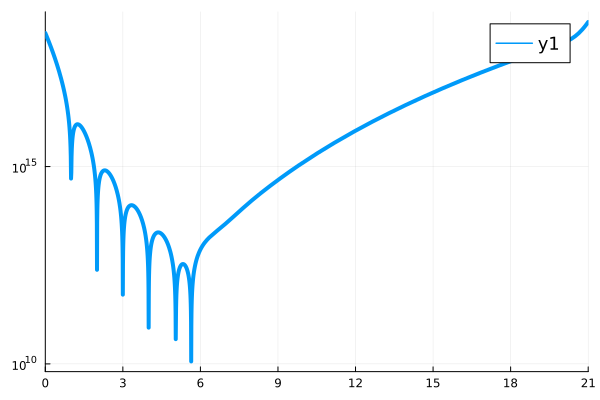

In [79]:
n = 20
a = collect(1.:n)
w = fromroots(a)
[w[10] *= 1 + 1e-10]
plot(x -> abs(w(x)), xlims=(0, n+1), yscale=:log10)

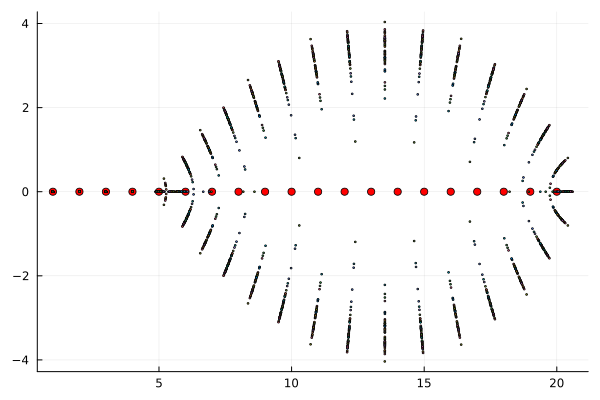

In [85]:
w = fromroots(a)
scatter(a, zero(a), color=:red)
for i in 1:100
    r = randn(length(w))
    q = copy(w); r[1:8] .= 0; r[10:end] .= 0
    q[:] .*= 1 .+ 1e-10 * r
    xs = roots(q)
    scatter!(real(xs), imag(xs), markersize=1)
end
plot!(legend=:none)

# Which is better to model inputs to a rootfinder?

* A: coefficients $a_k$ in $$p(x) = \prod_k (x - a_k)$$

* B: coefficients $b_k$ in $$p(x) = \sum_k b_k x^k$$

## Figure from Trefethen and Bau (1999)
<img alt="Ill conditioning of roots of Wilkinson's polynomial" src="../img/TB-Wilkinson.png" width="90%" />

# [Forward vs backward error and stability](https://fncbook.github.io/fnc/intro/stability.html#backward-error)

<img src="https://fncbook.github.io/fnc/_images/backwarderror.svg" width="90%" />

## Stability
**"nearly the right answer to nearly the right question"**
$$ \frac{\lvert \tilde f(x) - f(\tilde x) \rvert}{| f(\tilde x) |} \in O(\epsilon_{\text{machine}}) $$
for some $\tilde x$ that is close to $x$

## Backward Stability
**"exactly the right answer to nearly the right question"**
$$ \tilde f(x) = f(\tilde x) $$
for some $\tilde x$ that is close to $x$

* Every backward stable algorithm is stable.
* Not every stable algorithm is backward stable.

# Map angle to the unit circle

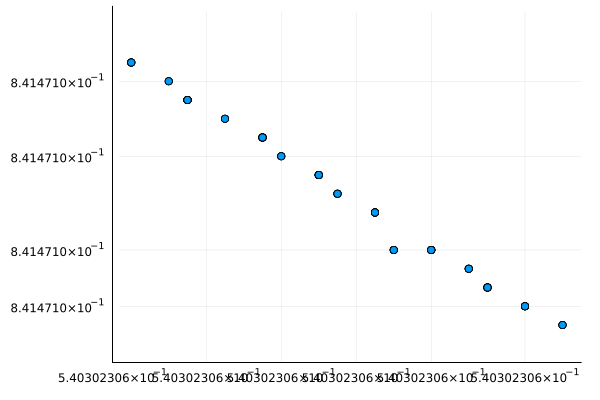

In [91]:
theta = 1 .+ LinRange(0, 3e-15, 100)
scatter(cos.(theta), sin.(theta), legend=:none, aspect_ratio=:equal)

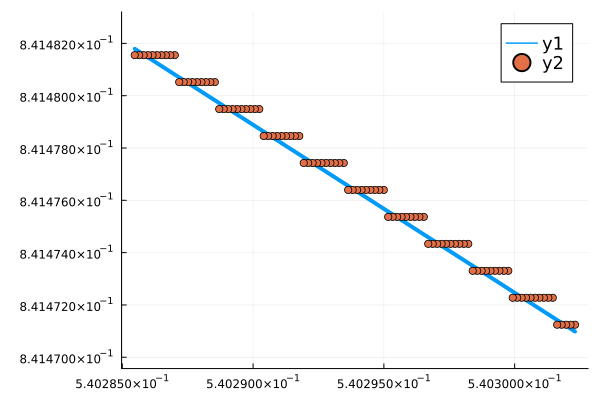

In [100]:
theta = 0 .+ LinRange(1., 1+2e-5, 100)
mysin(t) = cos(t - (1 + 1e10)*pi/2)
plot(cos.(theta), sin.(theta), aspect_ratio=:equal)
scatter!(cos.(theta), mysin.(theta))

## Are we observing A=stability, B=backward stability, or C=neither?

* The numbers $(\widetilde\cos \theta, \widetilde\sin \theta = (\operatorname{fl}(\cos \theta), \operatorname{fl}(\sin\theta))$ do not lie exactly on the unit circles.
  * There does not exist a $\tilde\theta$ such that $(\widetilde\cos \theta, \widetilde \sin\theta) = (\cos\tilde\theta, \sin\tilde\theta)$

# Accuracy of backward stable algorithms (Theorem)

A backward stable algorithm for computing $f(x)$ has relative accuracy
$$ \left\lvert \frac{\tilde f(x) - f(x)}{f(x)} \right\rvert \lesssim \kappa(f) \epsilon_{\text{machine}} . $$
Backward stability is generally the best we can hope for.

In practice, it is rarely possible for a function to be backward stable when the output space is higher dimensional than the input space.

# Beyond IEEE-754 double precision

## Lower precision IEEE-754 and relatives

The default floating point type in Python is `double` precision, which requires 8 bytes (64 bits) to store and offers $\epsilon_{\text{machine}} \approx 10^{-16}$.

* IEEE-754 **single precision** (`float` in C and related languages) is half the size (4 bytes = 32 bits) and has long been popular when adequate.
* IEEE-754 **half precision** reduces both range (exponent bits) and precision (mantissa) bits.
* **bfloat16** is a relatively new non-IEEE type that is popular in machine learning because it's easy to convert to/from single precision (just truncate/round the mantissa).


| Type | $\epsilon_{\text{machine}}$ | exponent bits | mantissa bits | diagram |
|-----|-----|---|---|---|
| double | 1.11e-16 | 11 | 52 | |
| single | 5.96e-8 | 8 | 23 | <img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg" width="120%" /> |
| [half](https://en.wikipedia.org/wiki/Half-precision_floating-point_format) | 4.88e-4 | 5 | 10 | <img src="https://upload.wikimedia.org/wikipedia/commons/2/21/IEEE_754r_Half_Floating_Point_Format.svg" width="100%" /> |
| [bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format) | 3.91e-3 | 8 | 7 | ![](https://upload.wikimedia.org/wikipedia/commons/0/0b/Bfloat16_format.svg) |

# Posits

<img src="../img/GustafsonPosits.png" width="90%" />

* [Gustafson and Yonemoto: **Beating Floating Point at its Own Game: Posit Arithmetic**](http://www.johngustafson.net/pdfs/BeatingFloatingPoint.pdf)
* [de Dinechin: **Posits: the good, the bad and the ugly**](https://people.eecs.berkeley.edu/~demmel/ma221_Fall20/Dinechin_etal_2019.pdf)
* [Interactive visualization](https://cse512-19s.github.io/FP-Well-Rounded/)
* [SoftPosit.jl](https://github.com/milankl/SoftPosit.jl) Julia package

# Mixed-precision algorithms

Sometimes reducing the precision (from double to single, or from single to half) compromises the quality of results (due to ill-conditioning or poor stability), but one can recover accurate results by using higher precision in a small fraction of the computation.  These are *mixed-precision algorithms*, and can be a useful optimization technique.

Such techniques can give up to 2x improvement if memory bandwidth (for floating point data) or pure vectorizable flops are the bottleneck.  In case of single to half precision, the benefit can be greater than 2x when using special hardware, such as GPUs with "tensor cores".

Warning: Premature use of mixed-precision techniques can often obscure better algorithms that can provide greater speedups and/or reliability improvements.